In [1]:
import torch
import torch.utils.data as Data
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

# Generate time series data

In [41]:
t = torch.linspace(0, 2*np.pi, 500).view(500, 1)
print(t.shape)

torch.Size([500, 1])


In [42]:
ts1 = 2*np.sin(t) + 3*np.cos(t)+0.1*torch.rand(t.size())
print(ts1.shape)

torch.Size([500, 1])


In [43]:
ts2 =  5*np.sin(t) + 2*np.cos(t)+0.2*torch.rand(t.size())
print(ts2.shape)

torch.Size([500, 1])


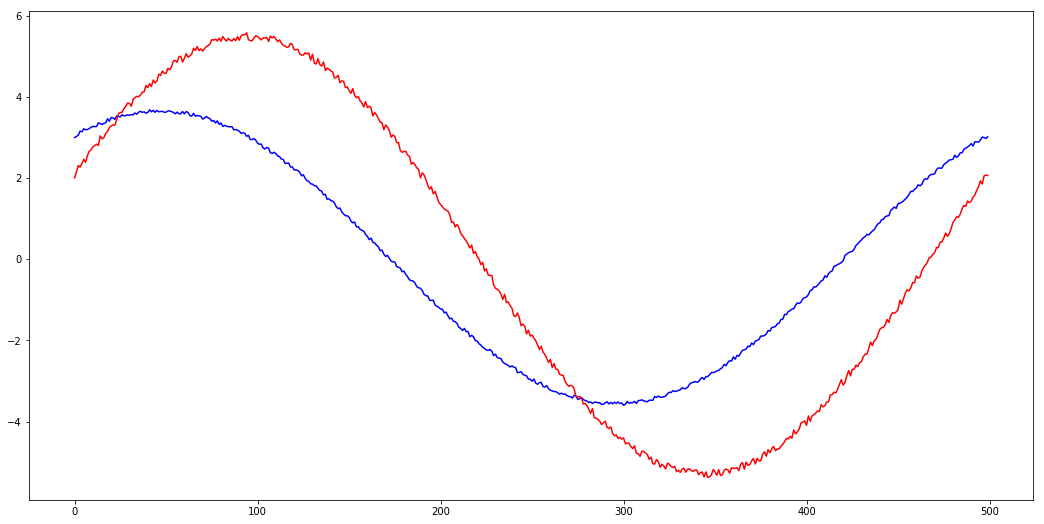

In [44]:
plt.figure(figsize=(18,9)) # set the figure size to 18 x 9 inches
plt.plot(ts1.numpy(), c='blue')
plt.plot(ts2.numpy(), c='red')
plt.show()

# Generate training x, y windows 

In [45]:
tensor = ts1[0:10]
print(tensor.shape)

torch.Size([10, 1])


In [46]:
tensor = ts1[0:10].view(1, 10, 1)
print(tensor.shape)

torch.Size([1, 10, 1])


In [47]:
train_x = ts1[0:10].view(1, 10, 1)
train_y = ts2[0:10].view(1, 10, 1)
begin = 1
time_step = 10
end = begin + time_step
while (end < 500):
    tmpx = ts1[begin: end]
    tmpy = ts2[begin: end]
    tmpx = tmpx.view(1, 10, 1)
    tmpy = tmpy.view(1, 10, 1)
    train_x = torch.cat((train_x, tmpx), 0)
    train_y = torch.cat((train_y, tmpy), 0)
    begin = begin + 1
    end = begin + time_step

In [48]:
print(train_x.shape, train_y.shape) # we have built 500 windows

torch.Size([490, 10, 1]) torch.Size([490, 10, 1])


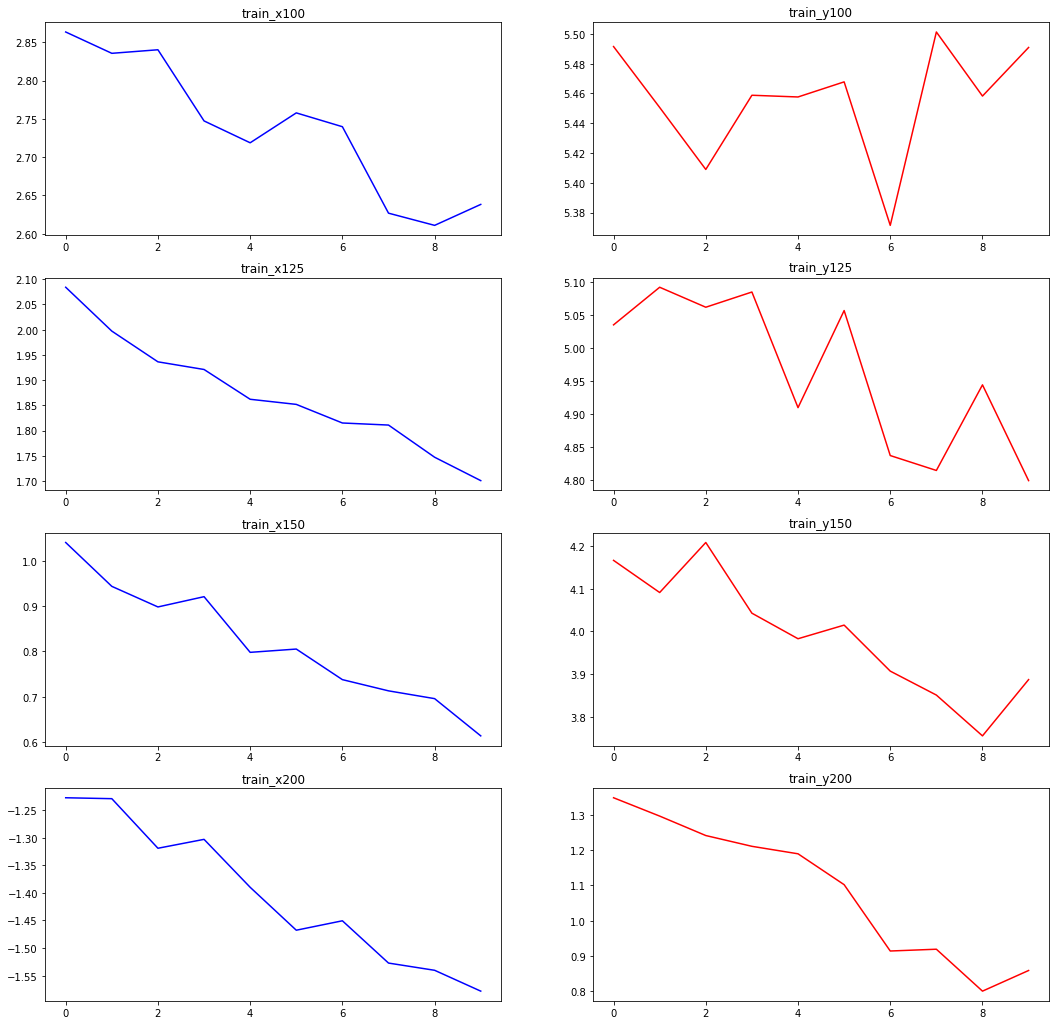

In [49]:
fig = plt.figure(figsize=(18, 18))
sub = 1
for i in [100, 125, 150, 200]:
    a=fig.add_subplot(4,2, sub) # we have a 2 rows * 4 columns subplots
    plt.plot(train_x[i].numpy(), c='blue')
    title = 'train_x' + str(i)
    plt.title(title)

    sub = sub +1
    a=fig.add_subplot(4,2, sub)
    plt.plot(train_y[i].numpy(), c='red')
    title = 'train_y' + str(i)
    plt.title(title)
    sub = sub + 1
plt.show()

# Build data loader

In [50]:
torch_dataset = Data.TensorDataset(data_tensor=train_x, target_tensor=train_y)

In [51]:
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=245,             # mini batch size 490/2=245
    shuffle=True,               # random shuffle for training
    num_workers=2,              # subprocesses for loading data
)

# Define NN

In [52]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

In [53]:
rnn = RNN()

In [54]:
rnn

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1)
)

# optimizer and loss function

In [55]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.2)   # optimize all cnn parameters
loss_func = nn.MSELoss()

# Run one traing epoc step by step to understand details

In [17]:
for step, (batch_x, batch_y) in enumerate(loader): 
    break

In [18]:
print(step, batch_x.shape, batch_y.shape)

0 torch.Size([250, 10, 1]) torch.Size([250, 10, 1])


In [19]:
b_x = Variable(batch_x)           
b_y = Variable(batch_y)       
print(b_x.shape, b_y.shape)

torch.Size([250, 10, 1]) torch.Size([250, 10, 1])


In [20]:
h_state = None      # for initial hidden state

In [21]:
prediction, h_state = rnn(b_x, h_state)

In [22]:
prediction.shape

torch.Size([250, 10, 1])

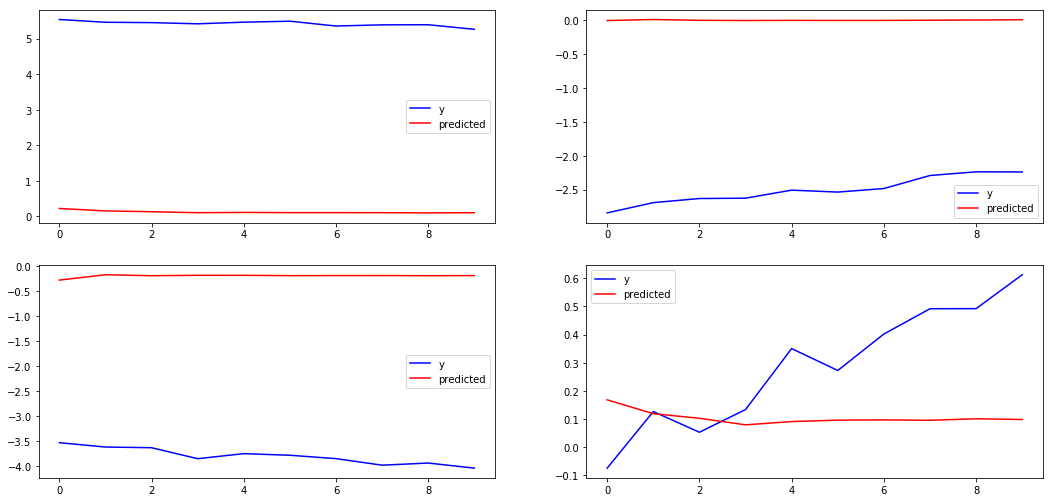

In [37]:
fig = plt.figure(figsize=(18, 18))
sub = 1
for i in [0, 50, 100, 150]:
    a=fig.add_subplot(4, 2, sub) # we have a 2 rows * 4 columns subplots
    plt.plot(b_y[i].data.numpy(), c='blue', label="y")
    plt.plot(prediction[i].data.numpy(), c='red', label = "predicted")
    plt.legend()
    sub = sub + 1
plt.show()

In [23]:
h_state

Variable containing:
( 0 ,.,.) = 
 -0.4745  0.2977 -0.2737  ...   0.2230 -0.4232  0.1370
  0.4705 -0.6433  0.3786  ...  -0.5774  0.6711 -0.3146
 -0.4787  0.2980 -0.2729  ...   0.2220 -0.4233  0.1369
           ...             ⋱             ...          
 -0.4924  0.3195 -0.2908  ...   0.2464 -0.4487  0.1442
 -0.3208  0.1185 -0.1629  ...   0.0616 -0.2253  0.0501
 -0.6066  0.4669 -0.4015  ...   0.3965 -0.6065  0.2093
[torch.FloatTensor of size 1x250x32]

In [24]:
loss = loss_func(prediction, b_y) 

In [25]:
loss

Variable containing:
 13.2933
[torch.FloatTensor of size 1]

In [26]:
loss.data.numpy()[0]

13.293275

# Training loop

In [56]:
h_state = None      # for initial hidden state

In [57]:
losslst = []
for epoch in range(30):  #run only one epoc
    for step, (batch_x, batch_y) in enumerate(loader):     
        b_x = Variable(batch_x)           
        b_y = Variable(batch_y)   

        prediction, h_state = rnn(b_x, h_state)   # rnn output
        # !! next step is important !!
        h_state = Variable(h_state.data)        # repack the hidden state, break the connection from last iteration

        loss = loss_func(prediction, b_y)         # cross entropy loss
        losslst.append(loss.data.numpy()[0])

        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                         # backpropagation, compute gradients
        optimizer.step()                        # apply gradients

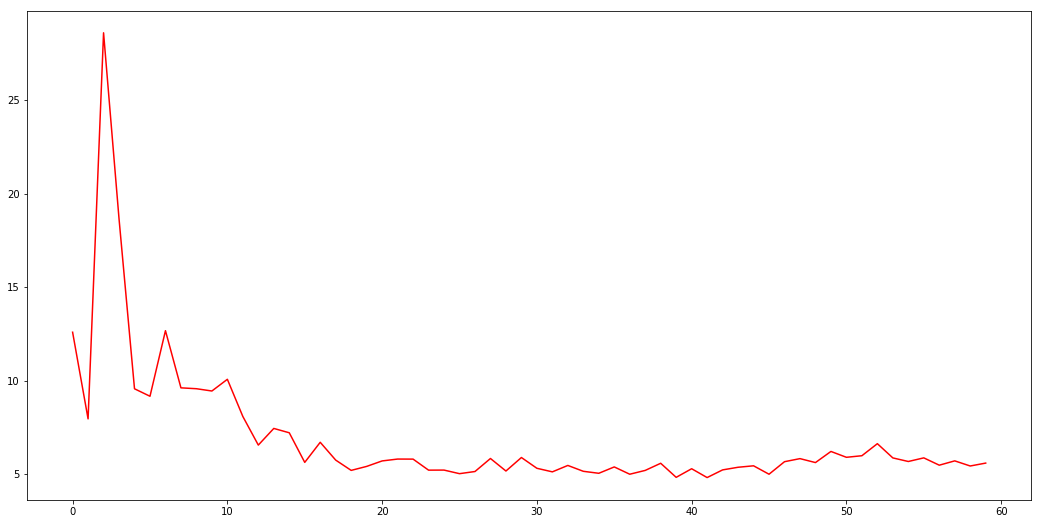

In [58]:
plt.figure(figsize=(18,9)) # set the figure size to 18 x 9 inches
plt.plot(losslst, color = 'red')
plt.show()

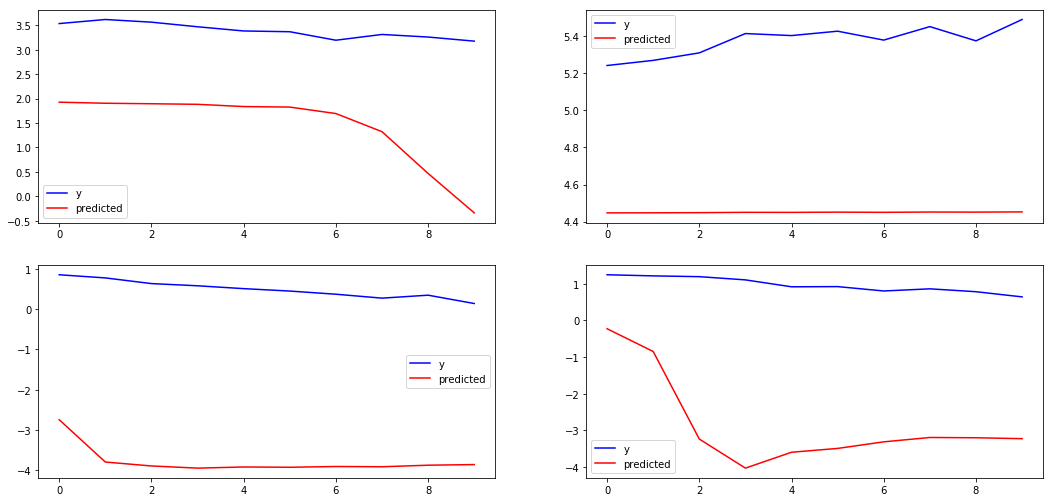

In [59]:
fig = plt.figure(figsize=(18, 18))
sub = 1
for i in [0, 50, 100, 150]:
    a=fig.add_subplot(4, 2, sub) # we have a 2 rows * 4 columns subplots
    plt.plot(b_y[i].data.numpy(), c='blue', label="y")
    plt.plot(prediction[i].data.numpy(), c='red', label = "predicted")
    plt.legend()
    sub = sub + 1
plt.show()